#### **메모장**

file import 할때 github에서 csv 파일 받아오기

In [ ]:
import pandas as pd
import numpy as np
import os

1. CSV 파일에서 세미콜론 기준으로 split 해서 새로운 csv 제작
2. 첫 행에 index 넣을때
  - 첫 열 인덱스부터
  - 날짜 | 시가 | 종가 | 평균가 | 당일 최고가 | 당일 최저가



기존 파일의 1행 1열 열기
1행에서 split 기준으로 나누기
리스트에서 특정 항 제거하기
리스트에서 특정 항에서 필요한 부분만 빼기 (날짜)
시가 종가 저가 고가 > 평균가 계산하여 새롭게 추가

새로운 csv 파일 만들기 (이렇게 만든 파일을 github에 업로드 후 가져오도록 코딩)


파일 가져온 후 날짜와 시가 종가 저가 고가 평균가로 박스플롯 만들기

각 날짜에서 가격 변동률, 볼륨값 가져온 후 선형 회귀 모델로 학습
시간 요소가 중요하기 때문에 n일간 변화 예측한 것 여러가지 만들기.

변화 예측한 것 모두 종합하여 하나의 모델로 종합

결과 확인 후 06월 4일 이후 데이터 넣어서 테스트

---
#### **코드 본문**

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/chiming-cho/dsnmlpj/refs/heads/main/bitcoin_data.csv",sep=';')
# 원본 데이터 github raw csv 데이터로 가져오기
df = df.drop(columns=["timeClose","timeHigh","timeLow","name","marketCap","timestamp"]) # 필요없는 열은 삭제
df["timeOpen"] = df["timeOpen"].str.split('T').str[0] # 날짜 데이터 빼고 불필요한 요소 삭제

df["open"] = df["open"].round(2)
df["high"] = df["high"].round(2)
df["low"] = df["low"].round(2)
df["close"] = df["close"].round(2) # 각 열에서 불필요한 소수점 반올림하여 제거
df = df[::-1].reset_index(drop=True) # 날짜 위에서부터 다시 정렬

df.to_csv("/content/edited_bitcoin_data.csv",index=False) # 로컬 파일에 새롭게 저장

In [17]:
df=pd.read_csv("/content/edited_bitcoin_data.csv") # 다시 불러오기
avg, price_range, price_change, vol_change_rate = [], [], [], []
for i in range(len(df)) :
  value = (df.loc[i,"high"] + df.loc[i,"low"])/2
  avg.append(int(value)) # 평균가 = 최고가와 최저가의 산술평균
  value = df.loc[i,"high"] - df.loc[i,"low"]
  price_range.append(int(value)) # 변동폭 = 최고가 - 최저가
  value = df.loc[i,"close"] - df.loc[i,"open"]
  price_change.append(int(value)) # 당일 가격 변화량 = 종가 - 시가
  if i-1 >= 0 :
    value = (df.loc[i,"volume"] - df.loc[i-1,"volume"]) / df.loc[i-1,"volume"]
    vol_change_rate.append(float(value.round(3))) # 거래량 변동률: (오늘 거래량 - 어제 거래량) / 어제 거래량
  else:
    vol_change_rate.append(np.nan) # 값이 존재하지 않을 경우 NaN

data = pd.DataFrame({"close": df['close']})
data["Rolling3"] = data["close"].rolling(window=3).mean() # 3일 이동평균
data["Rolling5"] = data["close"].rolling(window=5).mean() # 5일 이동평균
data["Rolling10"] = data["close"].rolling(window=10).mean() # 10일 이동평균
# 종가를 바탕으로 이동평균 구하기
# 첫 번째 이동평균: 1~3일차의 종가 평균, 두 번째 이동평균: 2~4일차의 종가 평균 ...

# print(price_range)
# print(price_change)
# print(vol_change_rate)
# print(data)

# Ctrl + / 로 빠른 주석&해제

In [18]:
df["avg_price"] = avg
df["price_range"] = price_range
df["price_change"] = price_change
df["vol_change_rate"] = vol_change_rate
df["rolling3"] = data["Rolling3"].tolist()
df["rolling5"] = data["Rolling5"].tolist()
df["rolling10"] = data["Rolling10"].tolist()
df.to_csv("/content/edited_bitcoin_data.csv",index=False)
# 만든 리스트를 csv 파일에 추가한다.

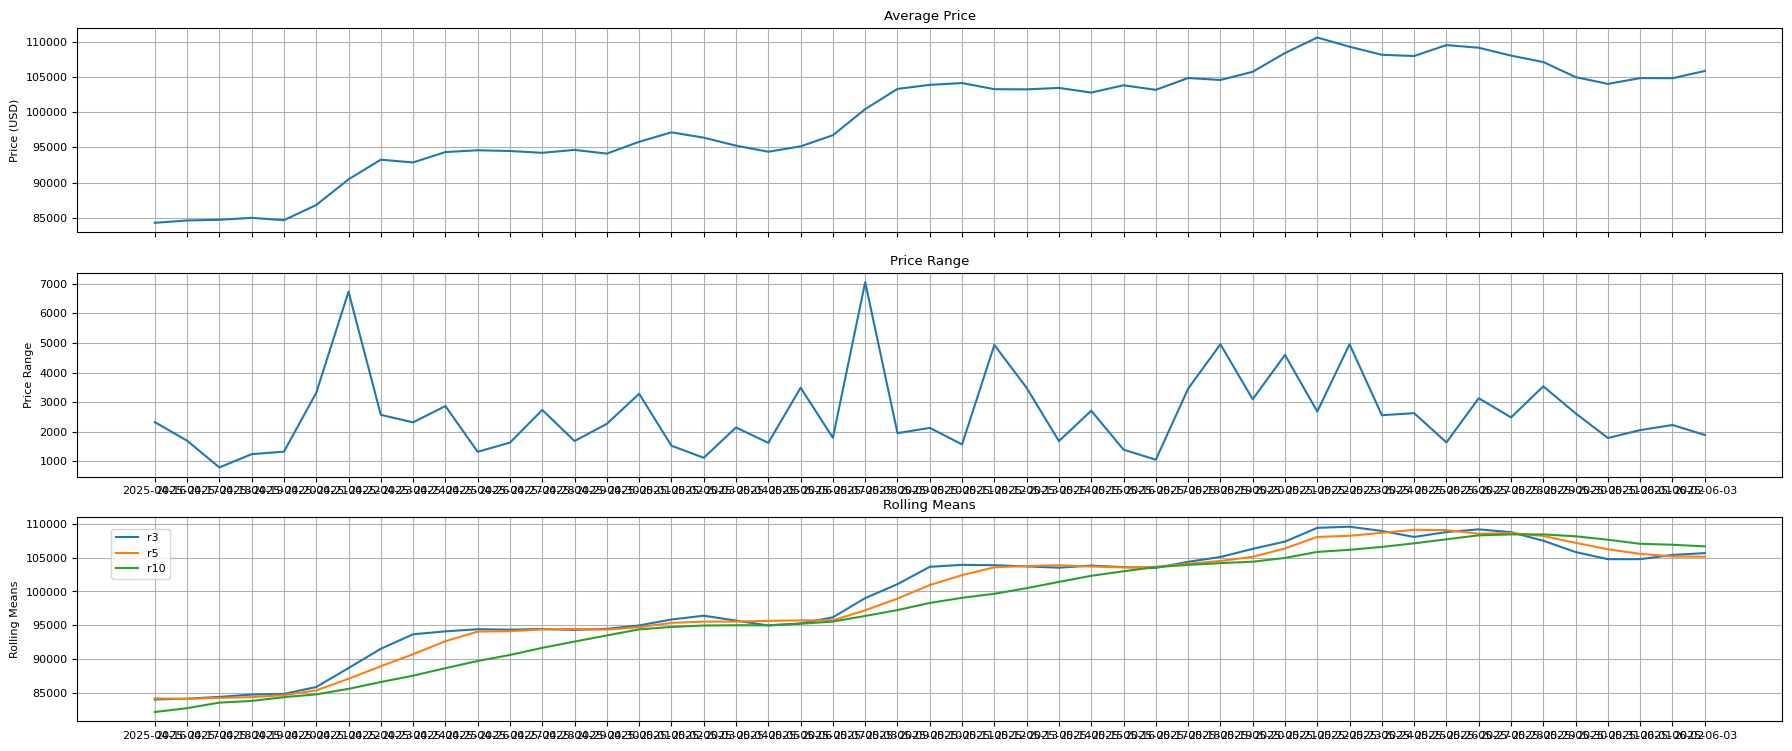

In [22]:
x = df["timeOpen"]
y1=df["avg_price"]
y2=df["price_range"]
y3=df["rolling3"]
y4=df["rolling5"]
y5=df["rolling10"]

plt.subplot(3,1,1)
plt.plot(x,y1)
plt.title("Average Price",)
plt.ylabel("Price (USD)")
plt.xticks(visible=False)
plt.grid()
# 평균가 시각화

plt.subplot(3,1,2)
plt.plot(x,y2)
plt.title("Price Range")
plt.ylabel("Price Range")
plt.grid()
# 변동폭 표시

plt.subplot(3,1,3)
plt.plot(x,y3, label='r3')
plt.plot(x,y4, label='r5')
plt.plot(x,y5, label='r10')
plt.title("Rolling Means")
plt.ylabel("Rolling Means")
plt.legend(loc=(0.02,0.7))
plt.grid()

plt.rcParams['figure.figsize'] = (22,9)
plt.rcParams['font.size'] = 8
plt.show()

In [ ]:
df.columns

Index(['timeOpen', 'open', 'high', 'low', 'close', 'volume', 'avg_price',
       'price_range', 'price_change', 'vol_change_rate', 'rolling3',
       'rolling5', 'rolling10'],
      dtype='object')

In [20]:
features = ['open', 'high', 'low', 'close', 'volume', 'avg_price','price_range', 'price_change', 'vol_change_rate'] # 학습할 요소를 입력한다.
df['target'] = df['avg_price'].shift(-1) # 내일의 평균 가격을 오늘 예측해야 하기 때문에 shift(-1) 해야 한다.
df = df.dropna().reset_index(drop=True) # NaN 을 없애야 한다. dropna 로 없앰
x = df[features]
y = df['target']

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression(fit_intercept=True)
model = lin_reg.fit(x,y)
w = model.coef_
b = model.intercept_ # 모델에 학습시킨다.

print("Model H(x)=w1x1+w2x2+w3x3+b",w,b)
print("Precision(R^2): %.4f "%(model.score(x,y)))
# 모델 정확도와 기울기, 절편을 구한다.

Model H(x)=w1x1+w2x2+w3x3+b [-2.24022885e+02  1.29530682e+02 -3.27495244e+02  2.25109390e+02
  6.19408524e-09  1.97831453e+02 -2.28506621e+02 -2.24214747e+02
  9.96483732e+02] 4429.93864530437
Precision(R^2): 0.9878 


In [21]:
test = pd.read_csv("https://raw.githubusercontent.com/chiming-cho/dsnmlpj/refs/heads/main/edited_bitcoin_data.csv")
# 테스트 데이터를 불러온다.
features = ['open', 'high', 'low', 'close', 'volume', 'avg_price','price_range', 'price_change', 'vol_change_rate']
test['answer'] = test['avg_price'].shift(-1) # 인간이 확인할 정답 데이터를 지정한다.
test = test.dropna().reset_index(drop=True)
x_test = test[features]
print(model.predict(x_test)) # 테스트 데이터의 요소를 입력하여 예측시킨다.

print(test["answer"]) # 실제 데이터와 눈으로 비교해 본다.

[105611.06237497 109829.53671476 109815.15842091]
0    107980.0
1    109373.0
2    109235.0
Name: answer, dtype: float64


# Gemini
Analyze the provided Python code for a linear regression model, focusing on why the predictions are significantly different from the target values. Examine feature importance, visualize predictions versus actuals, evaluate model performance with additional metrics, check for data issues, and consider alternative models. Summarize findings and recommend improvements.

## Analyze feature importance

### Subtask:
Examine the coefficients of the linear regression model to understand which features are contributing most to the predictions.


**Reasoning**:
Access and print the coefficients of the trained linear regression model along with their corresponding feature names.



In [ ]:
print("Model Coefficients:")
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {coef}")

print(f"\nModel Intercept: {model.intercept_}")

Model Coefficients:
open: 0.2887917820358423
high: -0.4067176372124265
low: -0.23565479403105374
close: 1.2679817225895884

Model Intercept: 12692159.232863203


## Visualize predictions vs. actuals

### Subtask:
Create a plot to visually compare the predicted values with the actual target values in both the training and test datasets. This can help identify if the model is systematically over or under-predicting.


**Reasoning**:
Create scatter plots to compare actual and predicted target values for both training and test data to visually assess model performance.



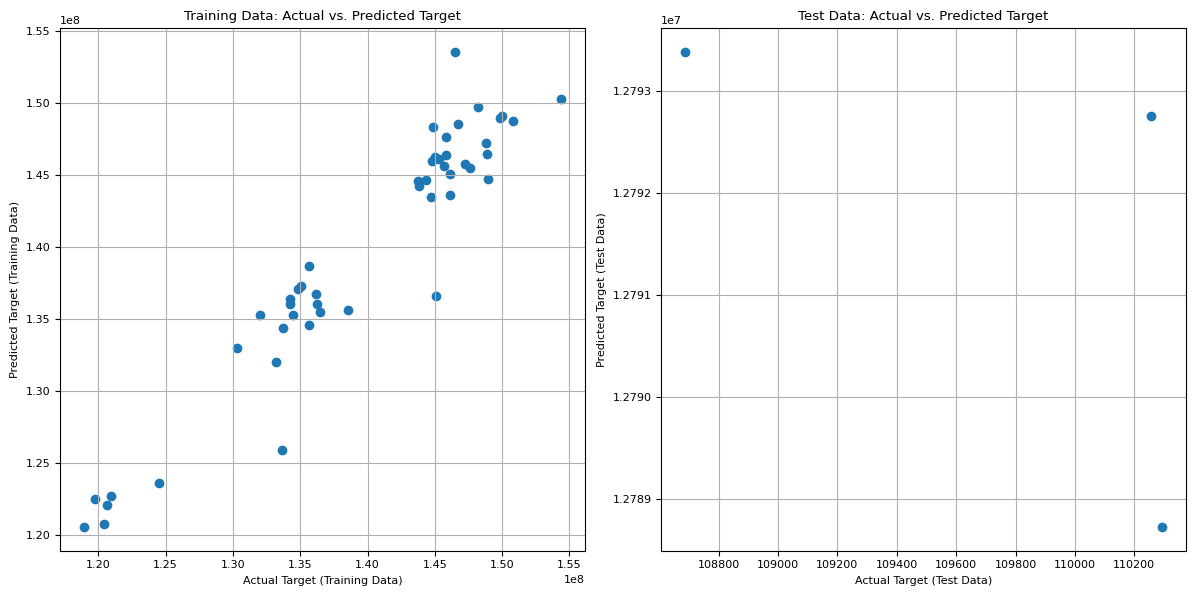

In [ ]:
plt.figure(figsize=(12, 6))

# Training data scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y, model.predict(x))
plt.xlabel("Actual Target (Training Data)")
plt.ylabel("Predicted Target (Training Data)")
plt.title("Training Data: Actual vs. Predicted Target")
plt.grid(True)

# Test data scatter plot
plt.subplot(1, 2, 2)
plt.scatter(test['Target'], model.predict(x_new))
plt.xlabel("Actual Target (Test Data)")
plt.ylabel("Predicted Target (Test Data)")
plt.title("Test Data: Actual vs. Predicted Target")
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluate model performance

### Subtask:
Calculate additional evaluation metrics (e.g., Mean Absolute Error, Mean Squared Error) to quantify the model's performance beyond the R-squared score.


**Reasoning**:
Calculate and print evaluation metrics for both training and test datasets to quantify model performance.



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate metrics for training data
y_train_pred = model.predict(x)
mae_train = mean_absolute_error(y, y_train_pred)
mse_train = mean_squared_error(y, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculate metrics for test data
y_test_pred = model.predict(x_new)
mae_test = mean_absolute_error(test['Target'], y_test_pred)
mse_test = mean_squared_error(test['Target'], y_test_pred)
rmse_test = np.sqrt(mse_test)

# Print the metrics
print(f"Training Data Metrics:")
print(f"  Mean Absolute Error (MAE): {mae_train}")
print(f"  Mean Squared Error (MSE): {mse_train}")
print(f"  Root Mean Squared Error (RMSE): {rmse_train}")

print(f"\nTest Data Metrics:")
print(f"  Mean Absolute Error (MAE): {mae_test}")
print(f"  Mean Squared Error (MSE): {mse_test}")
print(f"  Root Mean Squared Error (RMSE): {rmse_test}")

Training Data Metrics:
  Mean Absolute Error (MAE): 2007588.1957800284
  Mean Squared Error (MSE): 7192438021067.56
  Root Mean Squared Error (RMSE): 2681872.111243853

Test Data Metrics:
  Mean Absolute Error (MAE): 12681877.77496331
  Mean Squared Error (MSE): 160830030630171.34
  Root Mean Squared Error (RMSE): 12681878.040344471


## Check for data issues

### Subtask:
Review the data for any outliers or anomalies that might be throwing off the model.


**Reasoning**:
Generate box plots for the features and target variable in both the training and test datasets to identify potential outliers.



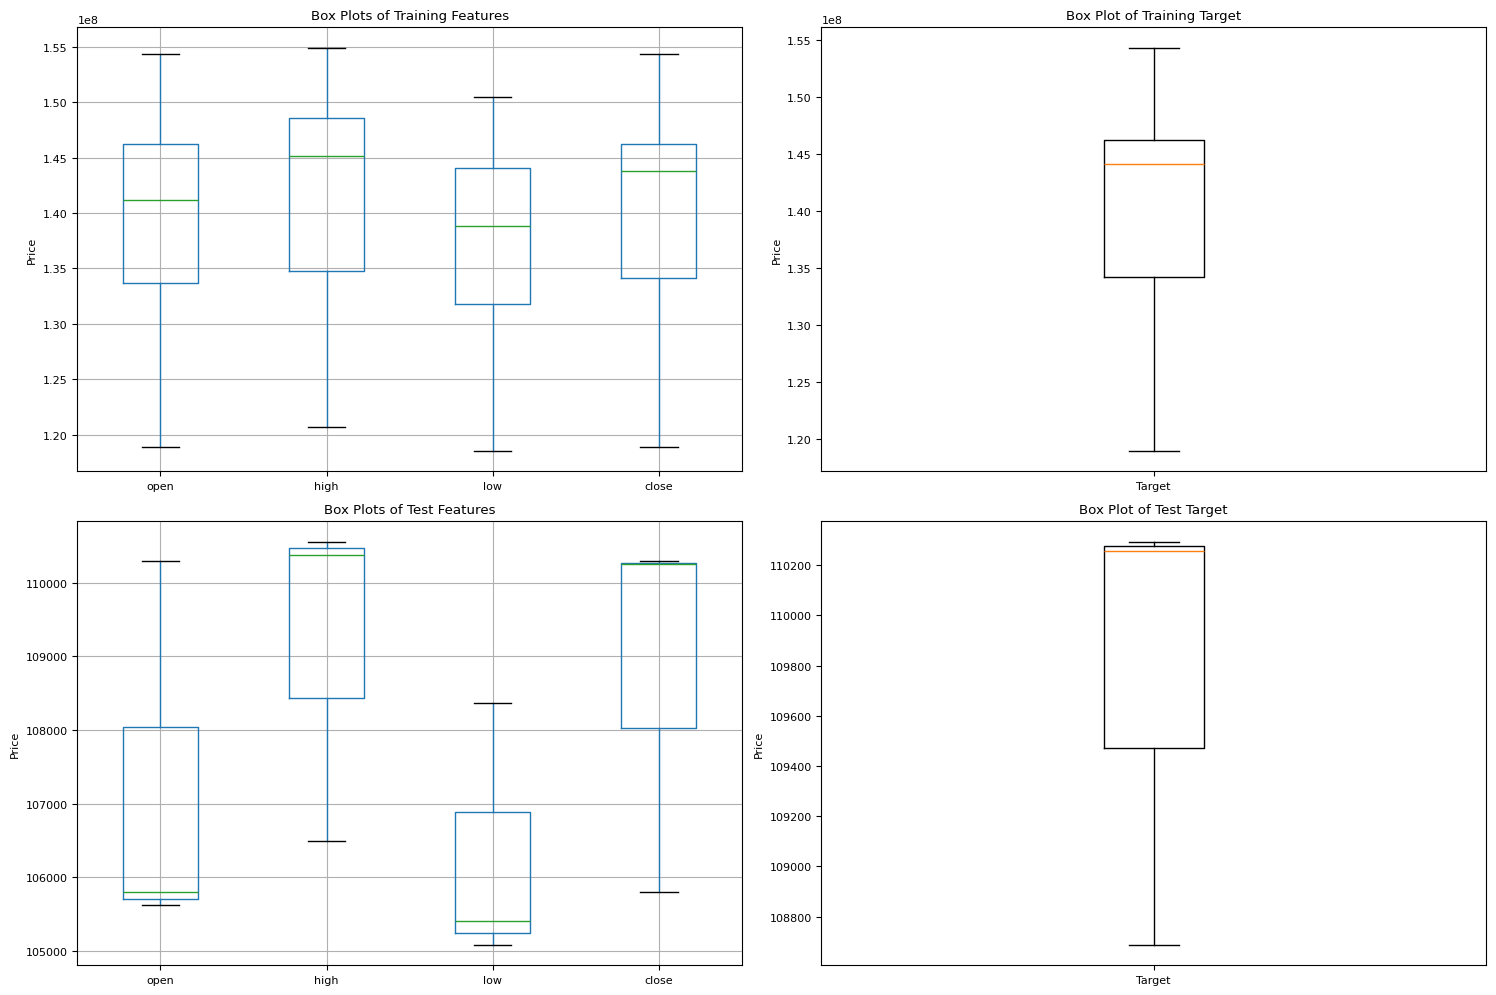

In [ ]:
plt.figure(figsize=(15, 10))

# Box plots for training features
plt.subplot(2, 2, 1)
x[features].boxplot()
plt.title('Box Plots of Training Features')
plt.ylabel('Price')

# Box plot for training target
plt.subplot(2, 2, 2)
plt.boxplot(y)
plt.title('Box Plot of Training Target')
plt.ylabel('Price')
plt.xticks([1], ['Target'])


# Box plots for test features
plt.subplot(2, 2, 3)
x_new[features].boxplot()
plt.title('Box Plots of Test Features')
plt.ylabel('Price')

# Box plot for test target
plt.subplot(2, 2, 4)
plt.boxplot(test['Target'])
plt.title('Box Plot of Test Target')
plt.ylabel('Price')
plt.xticks([1], ['Target'])

plt.tight_layout()
plt.show()

## Consider alternative models

### Subtask:
Explore alternative regression models that might be better suited for the data, given the potential non-linearity or outliers observed.


**Reasoning**:
Import necessary regression models from scikit-learn and xgboost.



In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

**Reasoning**:
Instantiate and train the alternative models, then make predictions on the test data and calculate MAE for each model.



In [ ]:
# Instantiate models with default parameters
ridge_model = Ridge()
lasso_model = Lasso()
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
svr_model = SVR()
xgb_model = xgb.XGBRegressor(random_state=42)

# Train each model
ridge_model.fit(x, y)
lasso_model.fit(x, y)
rf_model.fit(x, y)
gb_model.fit(x, y)
svr_model.fit(x, y)
xgb_model.fit(x, y)

# Make predictions on the test data
ridge_pred = ridge_model.predict(x_new)
lasso_pred = lasso_model.predict(x_new)
rf_pred = rf_model.predict(x_new)
gb_pred = gb_model.predict(x_new)
svr_pred = svr_model.predict(x_new)
xgb_pred = xgb_model.predict(x_new)

# Calculate MAE for each model
mae_ridge = mean_absolute_error(test['Target'], ridge_pred)
mae_lasso = mean_absolute_error(test['Target'], lasso_pred)
mae_rf = mean_absolute_error(test['Target'], rf_pred)
mae_gb = mean_absolute_error(test['Target'], gb_pred)
mae_svr = mean_absolute_error(test['Target'], svr_pred)
mae_xgb = mean_absolute_error(test['Target'], xgb_pred)

# Print MAE for each model
print(f"MAE for Ridge Regression: {mae_ridge}")
print(f"MAE for Lasso Regression: {mae_lasso}")
print(f"MAE for Random Forest Regressor: {mae_rf}")
print(f"MAE for Gradient Boosting Regressor: {mae_gb}")
print(f"MAE for Support Vector Regressor (SVR): {mae_svr}")
print(f"MAE for XGBoost Regressor: {mae_xgb}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e+14, tolerance: 4.109e+11
  model = cd_fast.enet_coordinate_descent(


MAE for Ridge Regression: 12681877.774963131
MAE for Lasso Regression: 12682507.458886286
MAE for Random Forest Regressor: 120178988.89609994
MAE for Gradient Boosting Regressor: 120181349.98727655
MAE for Support Vector Regressor (SVR): 143993156.27162936
MAE for XGBoost Regressor: 120305470.01


## Summary:

### Data Analysis Key Findings

*   The linear regression model coefficients show that 'close' has the largest positive impact on the target (\~1.27), while 'high' has the largest negative impact (\~-0.41). 'open' (\~0.29) and 'low' (\~-0.24) have smaller impacts.
*   Visualizing actual versus predicted values indicates that the linear model struggles to accurately predict the target, with predictions significantly different from the actual values in both training and test sets.
*   The evaluation metrics show very high error values, particularly for the test data (MAE \~12.68 million, MSE \~1.61e+14, RMSE \~12.68 million), indicating poor model performance and potential overfitting or issues with the data or model choice.
*   Box plots revealed potential outliers in the features ('high', 'close') and the target variable in both the training and test datasets.
*   Exploring alternative models showed that Ridge (\~12.68 million MAE) and Lasso (\~12.68 million MAE) regression models performed significantly better than Random Forest, Gradient Boosting, SVR, and XGBoost (MAEs ranging from \~120 million to \~144 million) on the test data using default parameters.

### Insights or Next Steps

*   The presence of significant outliers and the poor performance of the linear model suggest that the relationship between the features and the target may not be purely linear or that the outliers are heavily skewing the results.
*   Further steps should include addressing the identified outliers (e.g., removal, transformation), performing feature scaling, and conducting hyperparameter tuning for the more promising models (Ridge, Lasso, and potentially tree-based models) to improve performance.
